<a href="https://colab.research.google.com/github/MobinaSedaghat/multi-digit-ocr/blob/main/approach_2_crnn_sequence_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup & Dataset Download

In [ ]:
!wget https://www.orand.cl/orand_car/ORAND-CAR-2014.tar.gz
!tar -xvzf ORAND-CAR-2014.tar.gz

Streaming output truncated to the last 5000 lines.
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004006.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003727.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004368.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_006406.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005617.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005230.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003850.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003293.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004967.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005234.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005513.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003051.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004463.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005193.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004030.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004672.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003002.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005737

In [ ]:
DATA_ROOT = "/content/ORAND-CAR-2014"

CAR_A = {
    "train_img": f"{DATA_ROOT}/CAR-A/a_train_images",
    "train_lbl": f"{DATA_ROOT}/CAR-A/a_train_gt.txt",
    "test_img":  f"{DATA_ROOT}/CAR-A/a_test_images",
    "test_lbl":  f"{DATA_ROOT}/CAR-A/a_test_gt.txt"
}

CAR_B = {
    "train_img": f"{DATA_ROOT}/CAR-B/b_train_images",
    "train_lbl": f"{DATA_ROOT}/CAR-B/b_train_gt.txt",
    "test_img":  f"{DATA_ROOT}/CAR-B/b_test_images",
    "test_lbl":  f"{DATA_ROOT}/CAR-B/b_test_gt.txt"
}


# Load Labels and Dataset Class



In [ ]:
def load_label_file(label_path):

    label_dict = {}
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                fname, label = parts
                label_dict[fname] = label
    print(f"Loaded {len(label_dict)} labels from: {label_path}")
    return label_dict


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch
import os

class OCRDataset(Dataset):
    def __init__(self, img_dir, label_dict, target_height=80, target_width=320, augment=False):
        self.img_dir = img_dir
        self.label_dict = label_dict
        self.files = list(label_dict.keys())
        self.target_height = target_height
        self.target_width = target_width
        self.augment = augment
        self.char_to_idx = {str(i): i for i in range(10)}  # digits 0–9

        if self.augment:
            self.augmentation = T.Compose([
                T.RandomRotation(5, fill=255),
                T.RandomAffine(degrees=2, translate=(0.02, 0.02), scale=(0.95, 1.05), shear=5, fill=255),
                T.RandomPerspective(distortion_scale=0.2, p=0.3, fill=255),
            ])


    def resize_and_pad(self, img):

        # Resize image to fixed height, preserve aspect ratio, pad/crop to fixed width.

        original_w, original_h = img.size
        new_w = int(self.target_height * original_w / original_h)
        img = img.resize((new_w, self.target_height), Image.BILINEAR)

        if new_w < self.target_width:
            pad_left = (self.target_width - new_w) // 2
            pad_right = self.target_width - new_w - pad_left
            img = TF.pad(img, padding=(pad_left, 0, pad_right, 0), fill=255)

        else:

            img = img.crop((0, 0, self.target_width, self.target_height))
        return img

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        img_path = os.path.join(self.img_dir, fname)
        img = Image.open(img_path).convert("L")
        img = self.resize_and_pad(img)

        if self.augment:
            img = self.augmentation(img)

        img_tensor = TF.to_tensor(img)

        label_str = self.label_dict[fname]
        label = [self.char_to_idx[c] for c in label_str]

        return img_tensor, torch.tensor(label, dtype=torch.long)


# DataLoader Preparation

In [ ]:
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, 0)
    label_lengths = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels_concat = torch.cat(labels)
    return images, labels_concat, label_lengths


In [ ]:
from torch.utils.data import DataLoader

def prepare_dataloader(img_dir, label_path, batch_size=8, shuffle=True, augment=False):

    label_dict = load_label_file(label_path)
    dataset = OCRDataset(img_dir, label_dict, augment=augment)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
    return dataloader


In [ ]:


train_loader_a = prepare_dataloader(CAR_A["train_img"], CAR_A["train_lbl"], batch_size=8, shuffle=True, augment=True)
test_loader_a  = prepare_dataloader(CAR_A["test_img"],  CAR_A["test_lbl"],  batch_size=8, shuffle=False, augment=False)

train_loader_b = prepare_dataloader(CAR_B["train_img"], CAR_B["train_lbl"], batch_size=8, shuffle=True, augment=True)
test_loader_b  = prepare_dataloader(CAR_B["test_img"],  CAR_B["test_lbl"],  batch_size=8, shuffle=False, augment=False)


Loaded 2009 labels from: /content/ORAND-CAR-2014/CAR-A/a_train_gt.txt
Loaded 3784 labels from: /content/ORAND-CAR-2014/CAR-A/a_test_gt.txt
Loaded 3000 labels from: /content/ORAND-CAR-2014/CAR-B/b_train_gt.txt
Loaded 2926 labels from: /content/ORAND-CAR-2014/CAR-B/b_test_gt.txt


# Model Definition

In [ ]:
import torch.nn as nn
import torch

class CRNN(nn.Module):
    def __init__(self, img_h=80, num_channels=1, num_classes=11, rnn_hidden=256, rnn_layers=2):
        """
        num_classes includes blank class for CTC => 10 digits + 1 blank = 11
        """
        super(CRNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, 64, 3, padding=1), nn.ReLU(), nn.Dropout(0.1), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Dropout(0.1), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256), nn.Dropout(0.1),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(), nn.Dropout(0.1), nn.MaxPool2d((2, 1), (2, 1))
        )

        self.rnn = nn.LSTM(
            input_size=256 * (img_h // 8),
            hidden_size=rnn_hidden,
            num_layers=rnn_layers,
            dropout=0.2,
            bidirectional=True,
            batch_first=True
        )

        self.embedding = nn.Linear(rnn_hidden * 2, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 3, 1, 2)
        x = x.contiguous().view(x.size(0), x.size(1), -1)
        x, _ = self.rnn(x)
        x = self.embedding(x)
        return x.log_softmax(2)


# Training Utilities

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, labels, label_lengths in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = label_lengths.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.permute(1, 0, 2)

        input_lengths = torch.full(
            size=(images.size(0),),
            fill_value=outputs.size(0),
            dtype=torch.long,
            device=device
        )

        loss = criterion(outputs, labels, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f" Training Loss: {avg_loss:.4f}")
    return avg_loss


In [ ]:
def greedy_decoder(output, blank=10):

    arg_maxes = output.argmax(dim=2).permute(1, 0)
    decoded = []

    for seq in arg_maxes:
        pred = []
        prev = blank
        for idx in seq:
            idx = idx.item()
            if idx != blank and idx != prev:
                pred.append(idx)
            prev = idx
        decoded.append(pred)
    return decoded


In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_seq = 0
    correct_seq = 0
    total_digits = 0
    correct_digits = 0

    with torch.no_grad():
        for images, labels_concat, label_lengths in dataloader:
            images = images.to(device)
            outputs = model(images).permute(1, 0, 2)  # (seq_len, batch, num_classes)
            preds = greedy_decoder(outputs)

            labels_list = []
            start = 0
            for length in label_lengths:
                length = length.item()
                labels_list.append(labels_concat[start:start+length].tolist())
                start += length

            total_seq += len(preds)

            for pred_seq, true_seq in zip(preds, labels_list):
                if pred_seq == true_seq:
                    correct_seq += 1

                total_digits += len(true_seq)
                correct_digits += sum(1 for p, t in zip(pred_seq, true_seq) if p == t)

    seq_acc = correct_seq / total_seq
    digit_acc = correct_digits / total_digits
    print(f" Sequence Accuracy: {seq_acc:.4f} | Digit Accuracy: {digit_acc:.4f}")
    return seq_acc, digit_acc


# Training Loop

In [ ]:
def run_training(model, train_loader, test_loader, device, epochs=40, save_path="crnn_model.pth"):
    import torch.nn as nn
    import torch.optim as optim

    criterion = nn.CTCLoss(blank=10, zero_infinity=True)
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

    best_seq_acc = 0
    train_losses = []
    accs = []
    patience = 5
    wait = 0
    warmup_epochs = 5  #  No early stop/scheduler in first 5 epochs

    for epoch in range(epochs):
        print(f"\n Epoch {epoch+1}/{epochs}")
        loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(loss)

        print(" Evaluating on test set:")
        seq_acc, digit_acc = evaluate_model(model, test_loader, device)
        accs.append(seq_acc)

        if epoch >= warmup_epochs:
            scheduler.step(seq_acc)

            if seq_acc > best_seq_acc:
                best_seq_acc = seq_acc
                wait = 0
                torch.save(model.state_dict(), save_path)
                print(f" Best model saved with sequence accuracy {best_seq_acc:.4f}")
            else:
                wait += 1
                if wait >= patience:
                    print("⏹ Early stopping triggered.")
                    break
        else:
            if seq_acc > best_seq_acc:
                best_seq_acc = seq_acc
                torch.save(model.state_dict(), save_path)
                print(f" Best model saved with sequence accuracy {best_seq_acc:.4f}")

    print(" Training completed.")
    return train_losses, accs


In [ ]:
def load_model(model_class, device, model_path):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Using device:", device)

model_a = CRNN().to(device)

print("=== Training CRNN on Car A ===")
train_losses_a, accs_a = run_training(
    model_a, train_loader_a, test_loader_a, device,
    epochs=20, save_path="crnn_car_a.pth"
)


best_model_a = load_model(CRNN, device, "crnn_car_a.pth")
print("\n===  Final Evaluation on Car A Test Set ===")
evaluate_model(best_model_a, test_loader_a, device)


 Using device: cuda
=== Training CRNN on Car A ===

 Epoch 1/20
 Training Loss: 2.8873
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.0000

 Epoch 2/20
 Training Loss: 2.5283
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.0667

 Epoch 3/20
 Training Loss: 2.4939
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.1124

 Epoch 4/20
 Training Loss: 2.4610
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.1130

 Epoch 5/20
 Training Loss: 2.4296
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.1112

 Epoch 6/20
 Training Loss: 2.3772
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.1084

 Epoch 7/20
 Training Loss: 2.2956
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.1108

 Epoch 8/20
 Training Loss: 2.1506
 Evaluating on test set:
 Sequence Accuracy: 0.0005 | Digit Accuracy: 0.1325
 Best model saved with sequence accuracy 0.00

(0.794661733615222, 0.9337135540941628)

In [ ]:

model_b = CRNN().to(device)

print("\n===  Training CRNN on Car B ===")
train_losses_b, accs_b = run_training(
    model_b,
    train_loader_b,
    test_loader_b,
    device,
    epochs=20,
    save_path="crnn_car_b.pth"
)


best_model_b = load_model(CRNN, device, "crnn_car_b.pth")

print("\n===  Final Evaluation on Car B Test Set ===")
evaluate_model(best_model_b, test_loader_b, device)



===  Training CRNN on Car B ===

 Epoch 1/20
 Training Loss: 2.2004
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.0535

 Epoch 2/20
 Training Loss: 2.0005
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.0535

 Epoch 3/20
 Training Loss: 1.9952
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.0533

 Epoch 4/20
 Training Loss: 1.9815
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.0535

 Epoch 5/20
 Training Loss: 1.9510
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.0535

 Epoch 6/20
 Training Loss: 1.9027
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.0535

 Epoch 7/20
 Training Loss: 1.8209
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.0769

 Epoch 8/20
 Training Loss: 1.5461
 Evaluating on test set:
 Sequence Accuracy: 0.0003 | Digit Accuracy: 0.1826
 Best model saved with sequence accuracy 0.0003

 Epoch 9/20
 T

(0.861244019138756, 0.9608527844146296)

In [ ]:
from pathlib import Path
import os
import shutil

def prepare_joint_dataset_and_loader(
    car_a_img_dir, car_a_label_path,
    car_b_img_dir, car_b_label_path,
    joint_img_dir="/content/joint_train_images",
    batch_size=8,
    shuffle=True,
    augment=True
):
    label_dict_a = load_label_file(car_a_label_path)
    label_dict_b = load_label_file(car_b_label_path)

    label_dict_a_prefixed = {f"a_{k}": v for k, v in label_dict_a.items()}
    label_dict_b_prefixed = {f"b_{k}": v for k, v in label_dict_b.items()}
    joint_label_dict = {**label_dict_a_prefixed, **label_dict_b_prefixed}

    os.makedirs(joint_img_dir, exist_ok=True)
    for f in Path(joint_img_dir).glob("*"):
        if f.is_file() or f.is_symlink(): f.unlink()
        elif f.is_dir(): shutil.rmtree(f)

    for old_name in label_dict_a:
        src = os.path.join(car_a_img_dir, old_name)
        dst = os.path.join(joint_img_dir, f"a_{old_name}")
        if not os.path.exists(dst): os.symlink(src, dst)

    for old_name in label_dict_b:
        src = os.path.join(car_b_img_dir, old_name)
        dst = os.path.join(joint_img_dir, f"b_{old_name}")
        if not os.path.exists(dst): os.symlink(src, dst)

    print(f"Created joint training dataset with {len(joint_label_dict)} samples")

    dataset = OCRDataset(joint_img_dir, joint_label_dict, augment=augment)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
    return dataloader


In [ ]:
def prepare_combined_test_loader(
    img_dir_a, label_path_a,
    img_dir_b, label_path_b,
    joint_img_dir="/content/joint_test_images",
    batch_size=8
):
    label_dict_a = load_label_file(label_path_a)
    label_dict_b = load_label_file(label_path_b)

    label_dict_a_prefixed = {f"a_{k}": v for k, v in label_dict_a.items()}
    label_dict_b_prefixed = {f"b_{k}": v for k, v in label_dict_b.items()}
    joint_label_dict = {**label_dict_a_prefixed, **label_dict_b_prefixed}

    os.makedirs(joint_img_dir, exist_ok=True)
    for f in Path(joint_img_dir).glob("*"):
        if f.is_file() or f.is_symlink(): f.unlink()
        elif f.is_dir(): shutil.rmtree(f)

    for old_name in label_dict_a:
        os.symlink(os.path.join(img_dir_a, old_name), os.path.join(joint_img_dir, f"a_{old_name}"))

    for old_name in label_dict_b:
        os.symlink(os.path.join(img_dir_b, old_name), os.path.join(joint_img_dir, f"b_{old_name}"))

    dataset = OCRDataset(joint_img_dir, joint_label_dict, augment=False)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    print(f"Merged test loader with {len(joint_label_dict)} samples")


In [ ]:
# Prepare joint train loader
train_loader_joint = prepare_joint_dataset_and_loader(
    car_a_img_dir=CAR_A["train_img"],
    car_a_label_path=CAR_A["train_lbl"],
    car_b_img_dir=CAR_B["train_img"],
    car_b_label_path=CAR_B["train_lbl"],
    joint_img_dir="/content/joint_train_images",
    batch_size=8,
    shuffle=True,
    augment=True
)

# Train the model
model_joint = CRNN().to(device)

print(" Training CRNN on combined Car A + B...")
train_losses_joint, accs_joint = run_training(
    model_joint,
    train_loader_joint,
    test_loader_a,  # or use test_loader_b / merged
    device,
    epochs=20,
    save_path="crnn_joint_ab.pth"
)


Loaded 2009 labels from: /content/ORAND-CAR-2014/CAR-A/a_train_gt.txt
Loaded 3000 labels from: /content/ORAND-CAR-2014/CAR-B/b_train_gt.txt
Created joint training dataset with 5009 samples
 Training CRNN on combined Car A + B...

 Epoch 1/20
 Training Loss: 2.3940
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.0685

 Epoch 2/20
 Training Loss: 2.1936
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.0685

 Epoch 3/20
 Training Loss: 1.9252
 Evaluating on test set:
 Sequence Accuracy: 0.0000 | Digit Accuracy: 0.1336

 Epoch 4/20
 Training Loss: 0.7880
 Evaluating on test set:
 Sequence Accuracy: 0.2027 | Digit Accuracy: 0.4972
 Best model saved with sequence accuracy 0.2027

 Epoch 5/20
 Training Loss: 0.3462
 Evaluating on test set:
 Sequence Accuracy: 0.7532 | Digit Accuracy: 0.9122
 Best model saved with sequence accuracy 0.7532

 Epoch 6/20
 Training Loss: 0.2531
 Evaluating on test set:
 Sequence Accuracy: 0.7920 | Digit Accuracy: 0.93

# Visualization

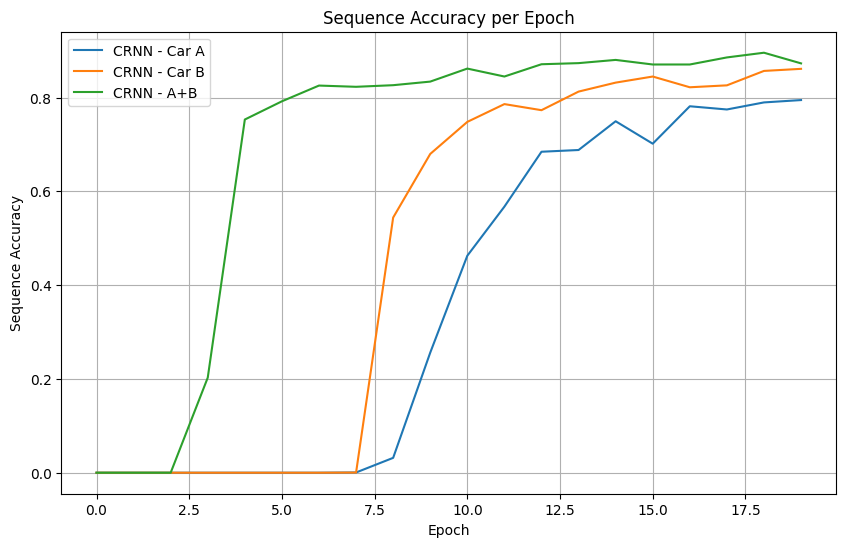

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(accs_a, label="CRNN - Car A")
plt.plot(accs_b, label="CRNN - Car B")
plt.plot(accs_joint, label="CRNN - A+B")
plt.title("Sequence Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Sequence Accuracy")
plt.legend()
plt.grid(True)
plt.show()


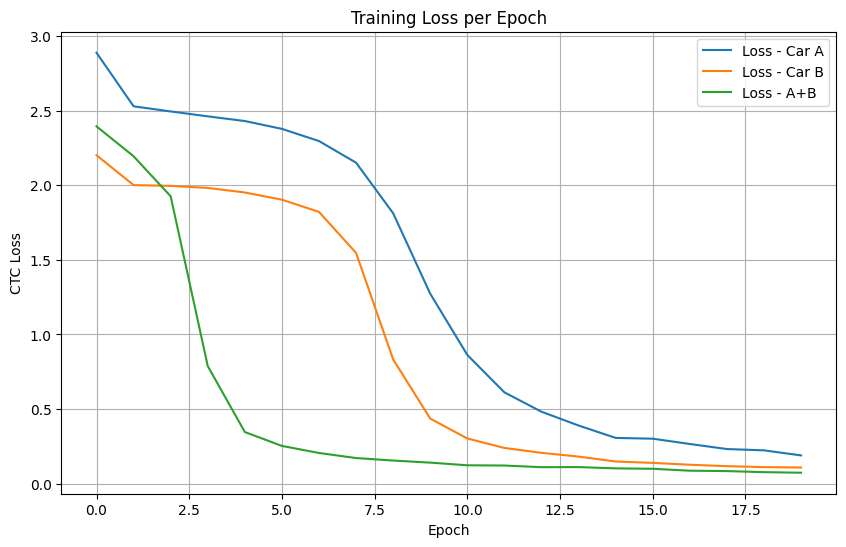

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_losses_a, label="Loss - Car A")
plt.plot(train_losses_b, label="Loss - Car B")
plt.plot(train_losses_joint, label="Loss - A+B")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("CTC Loss")
plt.legend()
plt.grid(True)
plt.show()


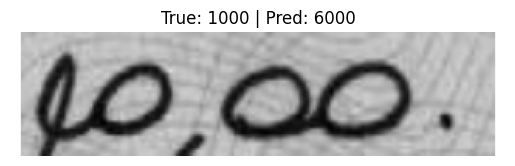

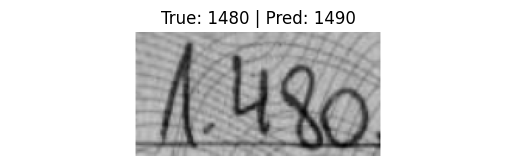

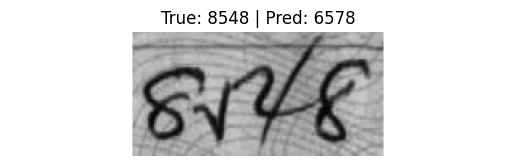

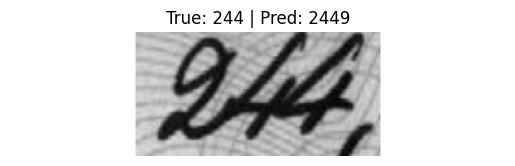

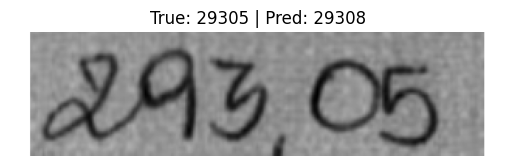

In [ ]:
import matplotlib.pyplot as plt

def show_misclassified_samples(model, dataloader, device, num_samples=5):
    model.eval()
    shown = 0

    with torch.no_grad():
        for images, labels_concat, label_lengths in dataloader:
            images = images.to(device)
            outputs = model(images).permute(1, 0, 2)
            preds = greedy_decoder(outputs)

            labels_list = []
            start = 0
            for length in label_lengths:
                labels_list.append(labels_concat[start:start+length].tolist())
                start += length

            for i, (pred_seq, true_seq) in enumerate(zip(preds, labels_list)):
                if shown >= num_samples:
                    return

                if pred_seq != true_seq:
                    img = images[i].cpu().squeeze(0).numpy()
                    plt.imshow(img, cmap='gray')
                    plt.title(f"True: {''.join(map(str, true_seq))} | Pred: {''.join(map(str, pred_seq))}")
                    plt.axis('off')
                    plt.show()
                    shown += 1


show_misclassified_samples(best_model_a, test_loader_a, device)


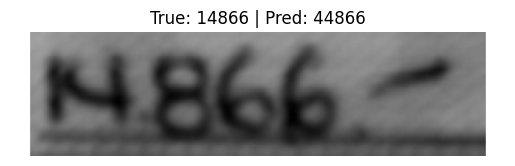

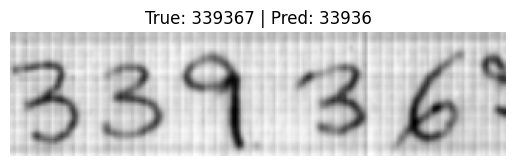

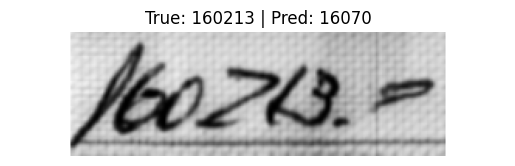

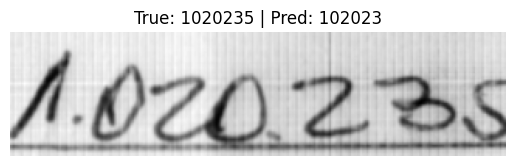

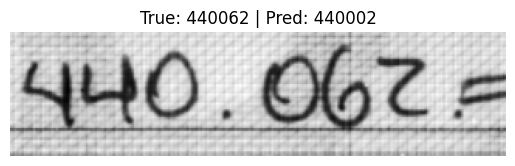

In [ ]:

show_misclassified_samples(best_model_b, test_loader_b, device)


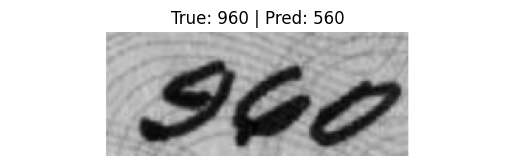

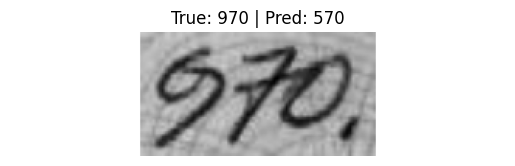

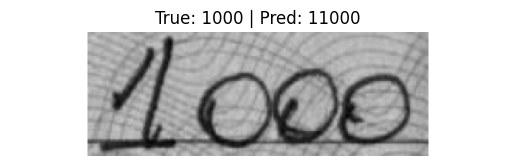

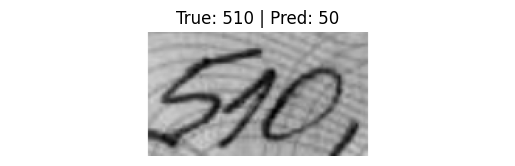

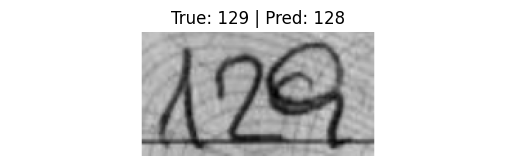

In [ ]:



show_misclassified_samples(model_joint, test_loader_a, device)


In [ ]:
model_a_loaded = load_model(CRNN, device, "crnn_car_a.pth")

print("\n=== Evaluation: loaded model_a tested on B ===")
evaluate_model(model_a_loaded, test_loader_b, device)



=== Evaluation: loaded model_a tested on B ===
 Sequence Accuracy: 0.6699 | Digit Accuracy: 0.8884


(0.6698564593301436, 0.8883783618207437)

In [ ]:
from torch.utils.data import Subset
import random

full_dataset_b = OCRDataset(CAR_B["train_img"], load_label_file(CAR_B["train_lbl"]), augment=True)
subset_size = int(0.2 * len(full_dataset_b))
subset_indices = random.sample(range(len(full_dataset_b)), subset_size)
subset_b = Subset(full_dataset_b, subset_indices)


from torch.utils.data import DataLoader
fine_tune_loader_b = DataLoader(subset_b, batch_size=8, shuffle=True, collate_fn=collate_fn)


Loaded 3000 labels from: /content/ORAND-CAR-2014/CAR-B/b_train_gt.txt


In [ ]:
print("\n=== Fine-tuning model A on 20% of B ===")
train_losses_ft, accs_ft = run_training(
    model_a_loaded,
    fine_tune_loader_b,
    test_loader_b,
    device,
    epochs=10,
    save_path="crnn_a_finetuned_on_b.pth"
)



=== Fine-tuning model A on 20% of B ===

 Epoch 1/10
 Training Loss: 0.3030
 Evaluating on test set:
 Sequence Accuracy: 0.7690 | Digit Accuracy: 0.9331
 Best model saved with sequence accuracy 0.7690

 Epoch 2/10
 Training Loss: 0.1880
 Evaluating on test set:
 Sequence Accuracy: 0.7922 | Digit Accuracy: 0.9385
 Best model saved with sequence accuracy 0.7922

 Epoch 3/10
 Training Loss: 0.1779
 Evaluating on test set:
 Sequence Accuracy: 0.7871 | Digit Accuracy: 0.9406

 Epoch 4/10
 Training Loss: 0.1480
 Evaluating on test set:
 Sequence Accuracy: 0.8031 | Digit Accuracy: 0.9416
 Best model saved with sequence accuracy 0.8031

 Epoch 5/10
 Training Loss: 0.1397
 Evaluating on test set:
 Sequence Accuracy: 0.8055 | Digit Accuracy: 0.9451
 Best model saved with sequence accuracy 0.8055

 Epoch 6/10
 Training Loss: 0.1305
 Evaluating on test set:
 Sequence Accuracy: 0.8096 | Digit Accuracy: 0.9490
 Best model saved with sequence accuracy 0.8096

 Epoch 7/10
 Training Loss: 0.1171
 Eval